## General Model



## Import useful packages

In [19]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import boto3
import io
from keras.utils import plot_model
import random



## Define functions to load the data


#### This code gets list of keys (ie files) in S3 bucket
(Should consider moving this into a helper file.)

In [20]:
def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                break

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    obj_list=[]
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        obj_list.append(obj["Key"])
    return(obj_list)


### Key image read-in functions: load_image and build_input

In [21]:
def load_image(s3_client,bucket_name,file_name, dim=(224,224)):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_name:  file to convert to image

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    #image = cv2.imread(image_path, 0)
    file_stream = io.BytesIO()
    s3.download_fileobj(bucket_name,file_name,file_stream)
    nparr = np.frombuffer(file_stream.getvalue(), np.uint8)
    image=cv2.imdecode(nparr,0)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [22]:
def build_input(s3_client,bucket_name,file_list,files_to_load,dim):
    """
    Loads all of the images into a single numpy array.
    Assumes that there are 101 equally-spaced images
    spanning lattitudes from 35N to 45N.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_list:  list of files in bucket
    Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.

    y:  A 1-dimensional numpy array of target lattitudes.
    """
    X = []
    i=0
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            print(file)
            image = load_image(s3_client,bucket_name,file,dim)
            X.append(image)
            if i%100==0:
                print('loaded:',i)
            i+=1
    return (np.array(X) / 255)

In [23]:
def build_labels(file_list,files_to_load):
    y = []
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            file_split = file.split('+')
            lat = float(file_split[0])
            long = float(file_split[1])
            y.append((lat, long))
    return np.array(y)

#### Test load_image on one image manually

(540, 960)


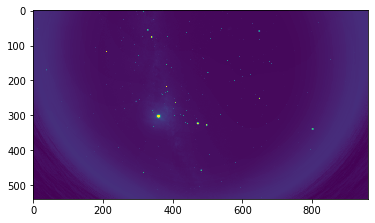

In [27]:
bucket_name='w251-final-project'
file_name='30.00016404896498+-54.75229869627509+2020-07-04T01:00:00.png'
s3 = boto3.client('s3')
sample_image = load_image(s3,bucket_name,file_name,(960,540))
plt.imshow(sample_image)
print(sample_image.shape)

## Prepare the data

### Load the images

In [28]:
#clear out models for memory management purposes
tf.keras.backend.clear_session()

#change this to true to force it to reload from S3 bucket
force_load=True

#check if np arrays have already been saved and load if so
if ((os.path.exists('x.npy'))&(not force_load)):
    print('loading from files')
    X=np.load('x.npy')
    y=np.load('y.npy')

#otherwise go to S3 bucket
else:
    print('loading from S3')
    bucket_name='w251-final-project'
    file_list=get_matching_s3_keys(bucket_name)
    
    #shuffle file list so that if take less than all are distributed.  also makes array randomly shuffled
    random.shuffle(file_list)
    
    s3 = boto3.client('s3')

    #max_files=100000
    max_files=5000
    file_list_length=len(file_list)
    files_to_load=np.minimum(max_files,file_list_length)

    #get images
    print('about to call build_input on',files_to_load,' files')
    dim=(960,540)
    X = build_input(s3,bucket_name,file_list,files_to_load,dim)


    #get labels
    print ('building labels')
    y = build_labels(file_list,files_to_load)
    
    print ('saving arrays so can reload more easily next time through')
    np.save('x.npy',X)
    np.save('y.npy',y)

print ('shape of image array:', X.shape)
print ('shape of label list:', y.shape)

loading from S3
about to call build_input on 1146  files
47.69577913189862+-66.16978244096275+2020-07-04T01:00:00.png
loaded: 0
48.67167397831324+-63.72741843886361+2020-07-04T01:00:00.png
33.31710316428832+-63.363608024485394+2020-07-04T01:00:00.png
34.12736510984574+-62.086792962375895+2020-07-04T01:00:00.png
41.49172821535063+-69.22471950800336+2020-07-04T01:00:00.png
49.81268992788385+-67.22530346189004+2020-07-04T01:00:00.png
44.67842296185552+-51.33388198455131+2020-07-04T01:00:00.png
46.23832029368242+-58.35542436791922+2020-07-04T01:00:00.png
37.62890857622461+-68.78723059726765+2020-07-04T01:00:00.png
43.061746549492035+-59.93693122588465+2020-07-04T01:00:00.png
34.951942679432605+-66.78528292544173+2020-07-04T01:00:00.png
43.3092020414395+-64.7065541026855+2020-07-04T01:00:00.png
39.89462038782472+-66.93778061189444+2020-07-04T01:00:00.png
48.695077863193475+-51.70125243116724+2020-07-04T01:00:00.png
32.97250252637291+-57.38560961657753+2020-07-04T01:00:00.png
46.174623978624

36.95756016649126+-54.34102341499998+2020-07-04T01:00:00.png
44.62746120521471+-56.464609087541895+2020-07-04T01:00:00.png
41.21422984738149+-59.946702973802175+2020-07-04T01:00:00.png
40.08827190847671+-54.92521644347345+2020-07-04T01:00:00.png
35.71529029440076+-56.16059229270155+2020-07-04T01:00:00.png
39.5423742091646+-52.06273934051143+2020-07-04T01:00:00.png
46.37744955107225+-61.181664584179316+2020-07-04T01:00:00.png
37.10987524298002+-63.28997052268387+2020-07-04T01:00:00.png
45.87712154958127+-57.981390653526155+2020-07-04T01:00:00.png
49.36788104163659+-66.35381157334545+2020-07-04T01:00:00.png
43.47129945512317+-50.12883843460138+2020-07-04T01:00:00.png
41.01942313866833+-56.487958749868085+2020-07-04T01:00:00.png
30.489294837874382+-69.76199520435365+2020-07-04T01:00:00.png
42.416368129205594+-65.3949725770978+2020-07-04T01:00:00.png
44.84031915525358+-59.84690265034159+2020-07-04T01:00:00.png
42.75734902251838+-59.910536675793686+2020-07-04T01:00:00.png
48.30906422293813+

31.153363129022246+-55.48553951573636+2020-07-04T01:00:00.png
32.17936976186147+-62.85294514791275+2020-07-04T01:00:00.png
44.939620260740604+-51.85592694514524+2020-07-04T01:00:00.png
32.26503933791971+-62.429041125637404+2020-07-04T01:00:00.png
46.37655115120316+-50.839744009905175+2020-07-04T01:00:00.png
43.81696411903689+-67.35373830868122+2020-07-04T01:00:00.png
40.01811367203389+-52.376121869639746+2020-07-04T01:00:00.png
30.756514481300528+-61.82152544076151+2020-07-04T01:00:00.png
46.220341444236595+-59.24549732560028+2020-07-04T01:00:00.png
39.18125939673098+-67.51154467983449+2020-07-04T01:00:00.png
35.992028743627195+-54.76549737874837+2020-07-04T01:00:00.png
40.419036334647544+-58.001328573544434+2020-07-04T01:00:00.png
49.66453546629896+-57.753065238767306+2020-07-04T01:00:00.png
45.77323892265177+-62.17732306516624+2020-07-04T01:00:00.png
39.80397429696994+-69.98093444531168+2020-07-04T01:00:00.png
35.34904570394036+-53.16687480485596+2020-07-04T01:00:00.png
46.7851179736

43.283048889545185+-50.68823697888201+2020-07-04T01:00:00.png
33.10777876753684+-63.00754024606847+2020-07-04T01:00:00.png
39.05163910083057+-56.434784940380524+2020-07-04T01:00:00.png
43.15406196371945+-68.6469325651505+2020-07-04T01:00:00.png
48.904968963361476+-69.95322932234347+2020-07-04T01:00:00.png
44.01043214010098+-53.786070869446164+2020-07-04T01:00:00.png
35.41157363391092+-62.45654419876852+2020-07-04T01:00:00.png
40.45415990274936+-62.001018048817926+2020-07-04T01:00:00.png
33.46547417589638+-56.46395643349376+2020-07-04T01:00:00.png
48.61788500804754+-61.9112071746733+2020-07-04T01:00:00.png
32.013327810956575+-68.29486772014442+2020-07-04T01:00:00.png
41.43878135606778+-60.34752304139033+2020-07-04T01:00:00.png
43.83301689914889+-66.09844596430217+2020-07-04T01:00:00.png
42.53403251936018+-54.07235575444132+2020-07-04T01:00:00.png
43.74466716448205+-65.80893828682339+2020-07-04T01:00:00.png
42.54950659564386+-65.97305512869826+2020-07-04T01:00:00.png
39.062682141036206+-

33.35593369725534+-52.68496220772458+2020-07-04T01:00:00.png
35.80194571359725+-67.56260465405568+2020-07-04T01:00:00.png
46.445574255561326+-63.13219576647003+2020-07-04T01:00:00.png
36.28304540982803+-66.20255640389699+2020-07-04T01:00:00.png
32.8729667025386+-57.69741945160989+2020-07-04T01:00:00.png
38.728839169401795+-65.363015870623+2020-07-04T01:00:00.png
38.30541885174641+-51.494721024987086+2020-07-04T01:00:00.png
41.50111895478965+-52.06357529264857+2020-07-04T01:00:00.png
42.054288459531406+-58.62280672213558+2020-07-04T01:00:00.png
45.75646486707867+-50.33402625090513+2020-07-04T01:00:00.png
47.30487820363602+-55.6469286859672+2020-07-04T01:00:00.png
49.04326882802167+-60.67541201991685+2020-07-04T01:00:00.png
34.9273906618195+-54.65697999938169+2020-07-04T01:00:00.png
39.457630174821944+-54.983160483961726+2020-07-04T01:00:00.png
45.193958075847604+-57.58467938168934+2020-07-04T01:00:00.png
42.19103026545426+-67.51356420411581+2020-07-04T01:00:00.png
31.10794977009981+-62.

34.135622272977805+-52.75359418299938+2020-07-04T01:00:00.png
40.254624575089444+-63.65912785706796+2020-07-04T01:00:00.png
38.68054801416734+-62.30416889106357+2020-07-04T01:00:00.png
36.08610149945287+-54.77997526167606+2020-07-04T01:00:00.png
47.00186618705038+-55.85688512128996+2020-07-04T01:00:00.png
45.116944711976515+-64.28789690415779+2020-07-04T01:00:00.png
34.27870875864435+-54.42730536427493+2020-07-04T01:00:00.png
46.935955362003014+-53.192335493567086+2020-07-04T01:00:00.png
45.38182077845419+-60.885688313613834+2020-07-04T01:00:00.png
43.94273272929587+-66.79968268289046+2020-07-04T01:00:00.png
46.51020521104235+-61.410540336962214+2020-07-04T01:00:00.png
39.12982596725311+-59.39458659185704+2020-07-04T01:00:00.png
33.43576450317111+-60.3556572386222+2020-07-04T01:00:00.png
37.88055002851059+-60.01095451377827+2020-07-04T01:00:00.png
36.13131043695806+-60.301078547804096+2020-07-04T01:00:00.png
47.97288961413984+-69.66011094163184+2020-07-04T01:00:00.png
39.02030925843811

44.75173402306031+-57.70374437594916+2020-07-04T01:00:00.png
46.0028232155406+-67.60614820794225+2020-07-04T01:00:00.png
39.29209087400824+-60.321152632204104+2020-07-04T01:00:00.png
36.19095661458775+-68.53465119600986+2020-07-04T01:00:00.png
31.851757361338276+-55.42152039803204+2020-07-04T01:00:00.png
31.69120670187888+-54.7261077924033+2020-07-04T01:00:00.png
39.8183107242086+-62.12299641375244+2020-07-04T01:00:00.png
43.83121761138056+-54.119679234313196+2020-07-04T01:00:00.png
47.66369558357843+-54.53225536292088+2020-07-04T01:00:00.png
47.06623061297685+-66.69493476966628+2020-07-04T01:00:00.png
36.99706288442277+-69.82379490524131+2020-07-04T01:00:00.png
49.352518360197124+-51.215621972471354+2020-07-04T01:00:00.png
44.505417602043345+-67.33669315131546+2020-07-04T01:00:00.png
48.22922678653283+-59.81500639970524+2020-07-04T01:00:00.png
34.70148249723947+-68.8739372360462+2020-07-04T01:00:00.png
33.36570377719525+-65.5124900234214+2020-07-04T01:00:00.png
36.947687107754305+-63.

41.90673894624003+-68.7420166414216+2020-07-04T01:00:00.png
36.35755550518985+-68.02032774024181+2020-07-04T01:00:00.png
39.711822909132714+-60.339993865936655+2020-07-04T01:00:00.png
47.52324284805114+-57.721830227550456+2020-07-04T01:00:00.png
42.72345997773258+-60.07937624542123+2020-07-04T01:00:00.png
48.79354695253376+-60.11959018251104+2020-07-04T01:00:00.png
40.548705835166196+-51.34601773663067+2020-07-04T01:00:00.png
40.67232634141531+-65.0899461124111+2020-07-04T01:00:00.png
38.72242760322668+-51.63338852265183+2020-07-04T01:00:00.png
40.15995474216452+-50.91973661139687+2020-07-04T01:00:00.png
39.31092311536404+-64.5291496591204+2020-07-04T01:00:00.png
41.112584959664815+-68.62612405926423+2020-07-04T01:00:00.png
39.79132087387746+-62.11817064622785+2020-07-04T01:00:00.png
37.0452045234568+-60.27035297054677+2020-07-04T01:00:00.png
39.920867656692096+-64.02546233483096+2020-07-04T01:00:00.png
37.68348846989129+-60.23925656655791+2020-07-04T01:00:00.png
33.765504629818835+-54

30.065385210739382+-59.10384429820746+2020-07-04T01:00:00.png
48.71483783039503+-61.393646766633104+2020-07-04T01:00:00.png
45.504719918266005+-52.53901389183517+2020-07-04T01:00:00.png
34.85752637245547+-57.152501471358185+2020-07-04T01:00:00.png
33.66334431019963+-59.213877222574204+2020-07-04T01:00:00.png
39.62831974773286+-51.42040646322589+2020-07-04T01:00:00.png
49.1426581007202+-66.64871864515597+2020-07-04T01:00:00.png
30.360780738443733+-65.5373409808243+2020-07-04T01:00:00.png
42.55118239863603+-51.58197101895965+2020-07-04T01:00:00.png
45.40796882795381+-66.77681259388112+2020-07-04T01:00:00.png
38.280355878792385+-63.251025603263855+2020-07-04T01:00:00.png
46.78736400311715+-60.40477442186007+2020-07-04T01:00:00.png
47.194821753555345+-68.1671223416439+2020-07-04T01:00:00.png
48.82927333639401+-62.02578302275298+2020-07-04T01:00:00.png
35.73640649033001+-65.19970588467797+2020-07-04T01:00:00.png
30.19831248576813+-58.9871500805598+2020-07-04T01:00:00.png
43.510366626179945+


### Standardize the values

In [29]:
def scale_down(numbers):
    top=max(numbers)
    bottom=min(numbers)
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=[x-middle for x in numbers]
    revised=[x/number_range*2 for x in revised]
    return revised,top,bottom

def scale_up(numbers,top,bottom):
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=[x*number_range/2 for x in numbers]
    revised=[x+middle for x in revised]
    return revised

In [30]:
#just scaling down without normalizing
y[:,0],toplat,bottomlat=scale_down(y[:,0])
y[:,1],toplong,bottomlong=scale_down(y[:,1])

#y[:,0] = scale(y[:,0])
#y[:,1]=scale(y[:,1])

print (y[:,0].mean(),y[:,0].std())
print (y[:,1].mean(),y[:,1].std())

0.02818425699484571 0.5880019820465363
0.008090267871169092 0.5857015171236031


### Split into test and training sets

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(916, 540, 960)
(916, 2)
(230, 540, 960)
(230, 2)


### Add channel for CNN

In [32]:
#need to add channel for B&W for CNN
#https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

print(X_train.shape,y_train.shape)
X_train=np.expand_dims(X_train,axis=3)
X_val=np.expand_dims(X_val,axis=3)
print(X_train.shape,X_val.shape)

(916, 540, 960) (916, 2)
(916, 540, 960, 1) (230, 540, 960, 1)


## The model

[]

In [12]:
tf.keras.backend.clear_session()

In [20]:
input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [33]:
#model splits into lat long after convolutional layers

input_shape=(540,960,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Flatten()(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.5)(xlat)
xlat=tf.keras.layers.Dense(64,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.5)(xlong)
xlong=tf.keras.layers.Dense(64,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [34]:
print(model.summary())
#plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 540, 960, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 538, 958, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 269, 479, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 267, 477, 64) 36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

### Fit the model

In [35]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=10, batch_size=32)

Train on 916 samples, validate on 230 samples
Epoch 1/10
916/916 [==============================] - 118s 129ms/sample - loss: 0.6750 - regression_lat_loss: 0.3545 - regression_long_loss: 0.3136 - regression_lat_mean_squared_error: 0.3584 - regression_long_mean_squared_error: 0.3166 - val_loss: 0.0725 - val_regression_lat_loss: 0.0282 - val_regression_long_loss: 0.0405 - val_regression_lat_mean_squared_error: 0.0299 - val_regression_long_mean_squared_error: 0.0426
Epoch 2/10
916/916 [==============================] - 116s 127ms/sample - loss: 0.0538 - regression_lat_loss: 0.0276 - regression_long_loss: 0.0260 - regression_lat_mean_squared_error: 0.0276 - regression_long_mean_squared_error: 0.0262 - val_loss: 0.0269 - val_regression_lat_loss: 0.0110 - val_regression_long_loss: 0.0143 - val_regression_lat_mean_squared_error: 0.0116 - val_regression_long_mean_squared_error: 0.0154
Epoch 3/10
916/916 [==============================] - 114s 125ms/sample - loss: 0.0300 - regression_lat_loss: 

### Evaluate model performance

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


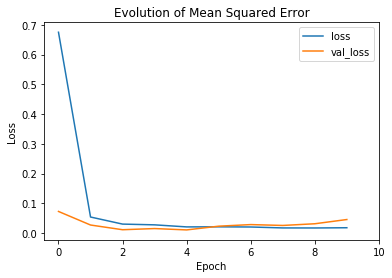

In [36]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [37]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

(30, 50)

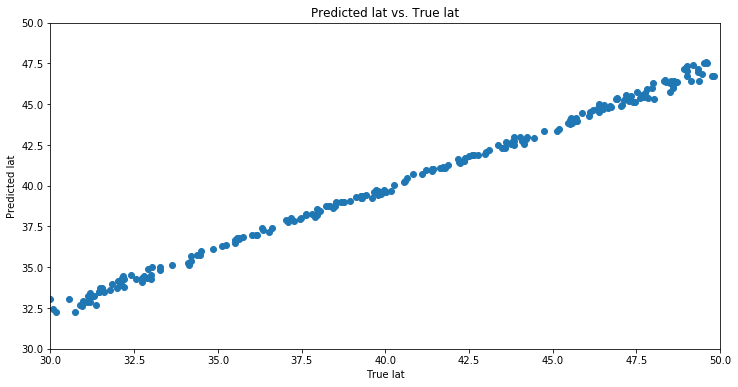

In [54]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
ax.set_xlim(30,50)
ax.set_ylim(30,50)
#draw straight line


(-70, -50)

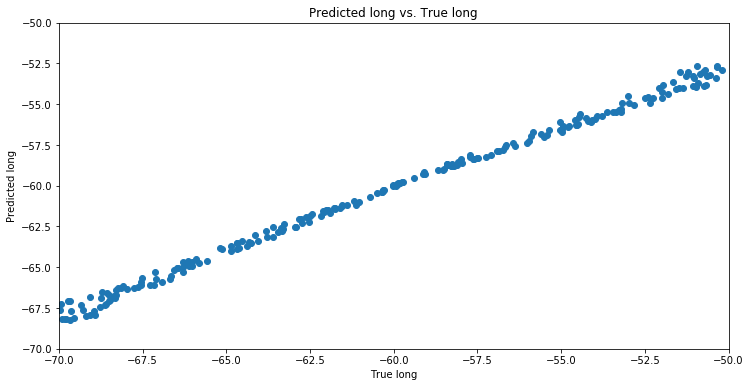

In [56]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
ax.set_xlim(-70,-50)
ax.set_ylim(-70,-50)


### Feed Forward Dense

In [38]:
#just dense

input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 50176)        0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 528)          26493456    flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 528)          279312      dense_11[0][0]                   
____________________________________________________________________________________________

In [39]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=20, batch_size=128)

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 8s 2ms/sample - loss: 2.0387 - regression_lat_loss: 0.8447 - regression_long_loss: 1.1658 - regression_lat_mean_squared_error: 0.8550 - regression_long_mean_squared_error: 1.1837 - val_loss: 0.6580 - val_regression_lat_loss: 0.3201 - val_regression_long_loss: 0.3377 - val_regression_lat_mean_squared_error: 0.3201 - val_regression_long_mean_squared_error: 0.3379
Epoch 2/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6928 - regression_lat_loss: 0.3413 - regression_long_loss: 0.3514 - regression_lat_mean_squared_error: 0.3413 - regression_long_mean_squared_error: 0.3516 - val_loss: 0.6555 - val_regression_lat_loss: 0.3144 - val_regression_long_loss: 0.3413 - val_regression_lat_mean_squared_error: 0.3143 - val_regression_long_mean_squared_error: 0.3412
Epoch 3/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6259 - regression_lat_loss: 0.30

In [40]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

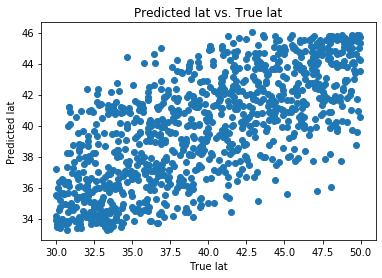

In [41]:
plt.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

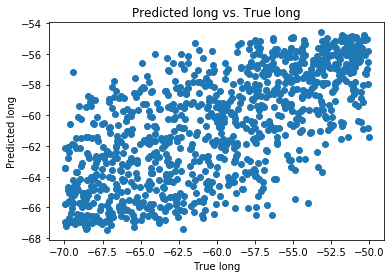

In [42]:
plt.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()

### Things to consider doing:
- don't normalize the lat and long - just scale it DONE
- convert back to lat and long DONE
- set validation batch size to deal with OOM errors (possibly) DONE
- loss weights?
- what is resolution of png files coming in?  are they squares?
- since set wide rectangle, need to make sure entirely at night time
- change angle of view - look more tired horizon?


### Old models

In [ ]:
# Define Input layer(s)
inputShape = (224, 224)
inputs = tf.keras.layers.Input(shape=inputShape)

flatten = tf.keras.layers.Flatten()(inputs)

x=tf.keras.layers.Dense(512,activation='relu')(flatten)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)


# Build and compile model
model_input = inputs
model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])